In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("covid_part2.ipynb")

# Final Project: COVID-19 Dataset
## Group Members: 

## Yucheng Jin, 3037442109, yuchengjin@berkeley.edu

## Tinna Liu, 3035729670, tinnaliu@berkeley.edu

## Jiayin Guo, 3035418572, guojiayin@berkeley.edu
## Exploring COVID-19 Data through Modeling
## Due Date: Thursday, December 13th, 11:59 PM
## Collaboration Policy

Data science is a collaborative activity. While you may talk with other groups about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others outside of your group please **include their names** at the top
of your notebook.


## This Assignment

In this final project, we will investigate COVID-19 data over the past year. This data contains information about COVID-19 case counts, mortalities, vaccination rates, and various other metadata that can assist in modeling various aspects of COVID-19.

Through this final project, you will demonstrate your experience with:
* Data cleaning and EDA using Pandas
* Unsupervised and supervised learning techniques
* Visualization


## Goal

Model and analyze the temporal evolution of COVID-19 mortalities or cases using one unsupervised and one supervised technique of your choice. Interpret your models' results through visualizations, and draw insightful conclusions about the modeling of COVID-19 data.

Recall that we studied linear and logistic regression, decision trees, random forests as part of supervised learning (with labels) and clustering, PCA as part of unsupervised learning (without labels). You are free to use any methods that you find suitable to answer the problem at hand.

In [2]:
# Run this cell to set up your notebook
import numpy as np
from geopy import *
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import *
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
import re

cases = pd.read_csv('data/time_series_covid19_confirmed_US.csv') # https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv
vaccinations = pd.read_csv('data/people_vaccinated_us_timeline.csv') # https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/people_vaccinated_us_timeline.csv
counties = pd.read_csv('data/co-est2020.csv', encoding='latin-1') # https://www2.census.gov/programs-surveys/popest/datasets/2010-2020/counties/totals/co-est2020.csv
mask_use = pd.read_csv('data/mask-use-by-county.csv') # https://github.com/nytimes/covid-19-data/blob/master/mask-use/mask-use-by-county.csv

<br/><br/><br/>

---

<br/><br/><br/>

## Data Cleaning (Again!)

For this section, please copy over the appropriate answers from your previous notebook submission.

### Part 1: Question 1a

Impute the null values in *all* the datasets with zero values or empty strings where appropriate.

<!--
BEGIN QUESTION
name: q1a
points: 0
-->

In [3]:
for column in cases.columns:
    if cases[column].dtype == str:
        cases[column].fillna("", inplace=True)
    else:
        cases[column].fillna(0, inplace=True)
        
for column in vaccinations.columns:
    if vaccinations[column].dtype == str:
        vaccinations[column].fillna("", inplace=True)
    else:
        vaccinations[column].fillna(0, inplace=True)
        
for column in counties.columns:
    if counties[column].dtype == str:
        counties[column].fillna("", inplace=True)
    else:
        counties[column].fillna(0, inplace=True)
        
for column in mask_use.columns:
    if mask_use[column].dtype == str:
        mask_use[column].fillna("", inplace=True)
    else:
        mask_use[column].fillna(0, inplace=True)

In [4]:
grader.check("q1a")

q1a results: All test cases passed!

### Part 1: Question 1d

Generate a valid FIPS code for the `counties` table.

*Hint*: Refer to [this](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt) guide on FIPS codes.

<!--
BEGIN QUESTION
name: q1d
points: 0
-->

In [5]:
def FIPS(row):
    if int(row['STATE']) < 10:
        state = '0' + str(row['STATE'])
    else:
        state = str(row['STATE'])
        
    if int(row['COUNTY']) < 10:
        county = '00' + str(row['COUNTY'])
    elif int(row['COUNTY']) < 100:
        county = '0' + str(row['COUNTY'])
    else:
        county = str(row['COUNTY'])
        
    return int(state+county)
    
counties['FIPS'] = counties.apply(FIPS, axis=1)

In [6]:
grader.check("q1d")

q1d results: All test cases passed!

### Part 1: Question 1e

Merge the `counties`, `cases`, and `mask_use` tables on an appropriate primary key to generate county-wise data.

<!--
BEGIN QUESTION
name: q1e
points: 0
-->

In [7]:
county_data = pd.merge(pd.merge(counties, cases, on='FIPS'), mask_use, right_on='COUNTYFP', left_on='FIPS')

In [8]:
grader.check("q1e")

q1e results: All test cases passed!

<br/><br/><br/>

---

<br/><br/><br/>

## Question 5: Guided Supervised Modeling

This section will guide you through creating a supervised learning framework that will predict the number of COVID-19 cases per capita given various COVID-19 safety protocols that have been implemented. Then, we will investigate the bias, variance, and observational noise of this framework.

Note that any answer responses without the appropriate work (i.e. code or math) will be subject to additional review and will not receive any credit.

<!-- BEGIN QUESTION -->

### Question 5a

We will use county-wise mask usage data to predict the number of COVID-19 cases on September 12th, 2021. Create a visualization that shows the pairwise correlation between each combination of column in the mask usage data and the number of COVID-19 cases.

*Hint*: You should be plotting 36 correlations.
<!--
BEGIN QUESTION
name: q5a
points: 3
manual: True
-->

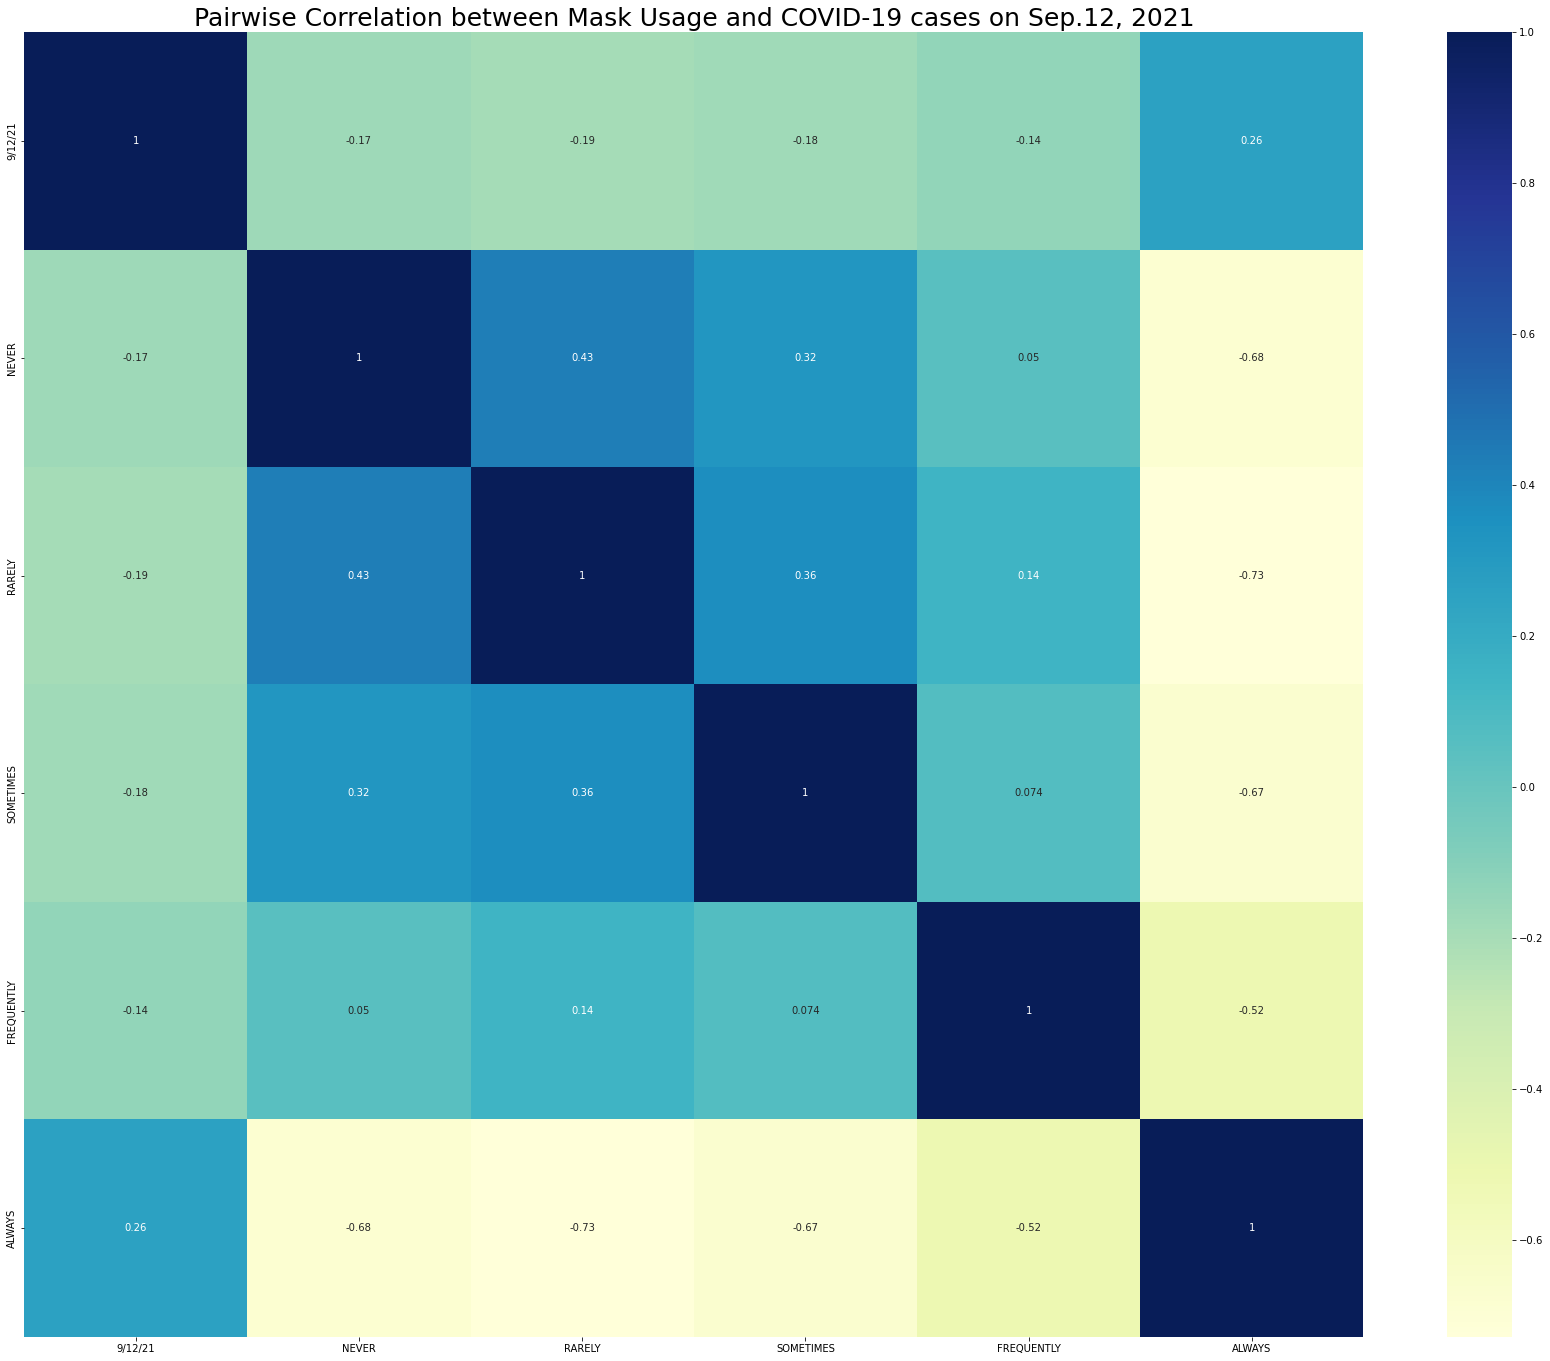

In [9]:
df_q5a = county_data[["9/12/21", "NEVER", "RARELY", "SOMETIMES", "FREQUENTLY", "ALWAYS"]]
plt.figure(figsize = (30,24))
dataplot = sns.heatmap(df_q5a.corr(), cmap="YlGnBu", annot=True)
plt.title("Pairwise Correlation between Mask Usage and COVID-19 cases on Sep.12, 2021", fontsize=25)
plt.show();

<!-- END QUESTION -->

### Question 5b

Train a linear regression model to predict the number of COVID-19 cases using county-wise mask usage data for September 12, 2021. Evaluate your model's RMSE on a held-out validation set with 33% of the county-wise data. When possible, make sure to set `random_state = 42` when splitting your data into training and test sets.
<!--
BEGIN QUESTION
name: q5b
points: 5
-->

In [10]:
def rmse(predicted, actual):
    return np.sqrt(np.mean((actual-predicted)**2))

from sklearn import linear_model as lm

X_q5b = county_data[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
y_q5b = county_data.loc[:, "9/12/21"]

X_q5b_train, X_q5b_test, y_q5b_train, y_q5b_test = train_test_split(X_q5b, y_q5b, test_size=0.33, random_state=42)

linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m1.fit(X_q5b_train, y_q5b_train)

y_train_predicted = linear_model_m1.predict(X_q5b_train)
y_test_predicted = linear_model_m1.predict(X_q5b_test)
train_rmse_cases = rmse(y_train_predicted, y_q5b_train)
test_rmse_cases = rmse(y_test_predicted, y_q5b_test)

train_rmse_cases, test_rmse_cases

(27834.430707426982, 62591.13087482178)

In [11]:
grader.check("q5b")

q5b results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5c

Explain potential reasons the test set RMSE is much higher as compared to the training set RMSE.
<!--
BEGIN QUESTION
name: q5c
points: 3
manual: True
-->

___Answer:___<br>
It's most possible that the overfitting happens because there are too much noise in the data. <br>
It's also possible that in different states and conties the relationship between mask usage and new cases is different due to different location and population density.

<!-- END QUESTION -->

### Question 5d

Instead of predicting the number of COVID-19 cases, redo part (b) by predicting the number of cases per capita. Report the model's RMSE on the training and validation set.

Comment on the relationship between the training and test RMSE by predicting the number of cases per capita instead of the total number of cases.
<!--
BEGIN QUESTION
name: q5d
points: 3
-->

In [12]:
q5d_data = county_data.copy()
q5d_data["9/12/21_capital"] = q5d_data.loc[:,'9/12/21'].div(q5d_data["POPESTIMATE2020"], axis=0)

X_q5d = q5d_data[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
y_q5d = q5d_data.loc[:, "9/12/21_capital"]
X_q5d_train, X_q5d_test, y_q5d_train, y_q5d_test = train_test_split(X_q5d, y_q5d, test_size=0.33, random_state=42)

linear_model_m2 = lm.LinearRegression(fit_intercept=True)
linear_model_m2.fit(X_q5d_train, y_q5d_train)

y_train_predicted_m2 = linear_model_m2.predict(X_q5d_train)
y_test_predicted_m2 = linear_model_m2.predict(X_q5d_test)

train_rmse_cpc = rmse(y_train_predicted_m2, y_q5d_train)
test_rmse_cpc = rmse(y_test_predicted_m2, y_q5d_test)

train_rmse_cpc, test_rmse_cpc
# Comment: The training and testing mse by using "the number of cases per capita" are pretty close.

(0.03540985737823185, 0.038167903498916037)

In [13]:
grader.check("q5d")

q5d results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5e

Visualize the model outputs from part (d) by plotting the predictions $\hat{y}$ versus the observations $y$. Comment on what the plot indicates about our linear model as a comment in the code cell.

<!--
BEGIN QUESTION
name: q5e
points: 3
manual: True
-->

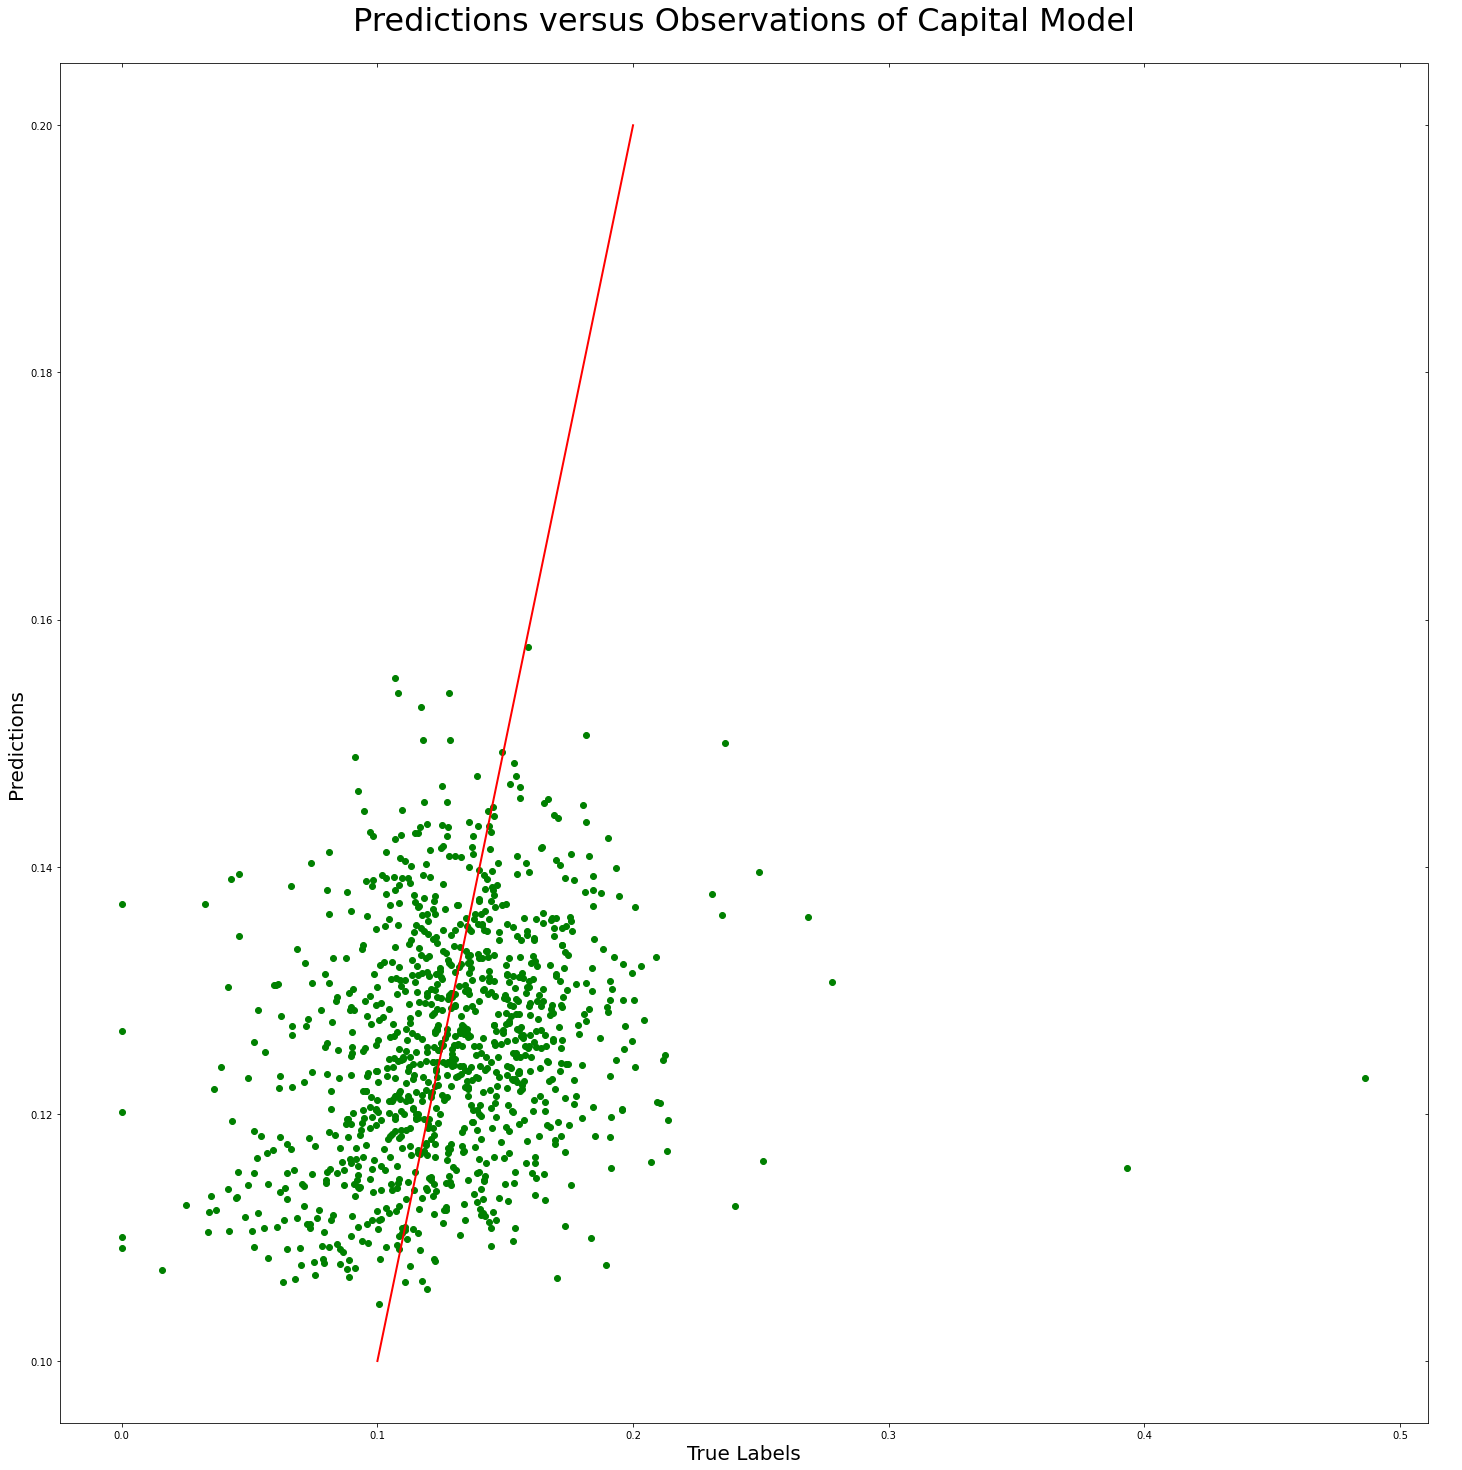

In [14]:
grid = sns.JointGrid(x=y_q5d_test, y=y_test_predicted_m2, space=0, size=20, ratio=50)
grid.plot_joint(plt.scatter, color="g")
plt.plot([0.1, 0.2], [0.1, 0.2], linewidth=2, color="red")
plt.xlabel(xlabel="True Labels", fontsize=20)
plt.ylabel(ylabel="Predictions", fontsize=20)
plt.title('Predictions versus Observations of Capital Model', fontsize=32, y=1.02);

# In the plot, except the outliers, the points are almost evenly distributed on both sides of line y=y_hat.
# This shows that if we draw the residual plot of this regression model, it will have a similar vertical spread throughout the entire plot and
# would not have clear patterns, which indicates our linear model has a decent accuracy.

<!-- END QUESTION -->

### Question 5f

We will investigate the bias and variance of this improved model on the test set using the bias-variance decomposition to formalize the behaviour of our model. To generate an empirical estimate of the errors and the parameters in the bias-variance decomposition, train 1000 bootstrapped models on the training dataset from part (d).

<!--
BEGIN QUESTION
name: q5f
points: 5
-->

In [15]:
train_set_5d = X_q5d.join(y_q5d)

def bootstrap_model(dataset, m=1000):
    size = len(dataset)
    bootstrapped_models = []
    for j in range(m):
        resample = dataset.sample(n=size, replace=True)
        X = resample[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]
        y = resample["9/12/21_capital"]
        model = lm.LinearRegression(fit_intercept=True)
        model.fit(X, y)
        bootstrapped_models.append(model)
    return bootstrapped_models

models = bootstrap_model(train_set_5d)

In [16]:
grader.check("q5f")

q5f results: All test cases passed!

### Question 5g

To investigate the variance in our test predictions, we sample a particular test point $(x_i, y_i)$ such that $i = 100$. In other words, we will use the 100th point in the test set from part (d), `(X_q5d_test.iloc[100], y_q5d_test.iloc[100])` as the testing point.

Generate predictions and square errors for this test point for all 1000 models, and calculate the *proportion* of the *expected* square error that is captured by the model prediction variance. In other words, we wish to estimate the following quantity:

$$
\frac{\mathrm{Var}(f_\theta(x_i))}{\mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]}
$$

*Hint*: Refer to the bias-variance decomposition from lecture.
<!--
BEGIN QUESTION
name: q5g
points: 5
-->

In [17]:
true_observation = y_q5d_test.iloc[100]
predictions = [model.predict(X_q5d_test.iloc[[100]]) for model in models]
square_errors = [(true_observation - prediction)**2 for prediction in predictions]

expected_se = np.mean(square_errors)
prediction_variance = np.var(predictions)

prop_var = prediction_variance/expected_se
prop_var

0.0009292818733834691

In [18]:
grader.check("q5g")

q5g results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 5h

Using the bias-variance decomposition, comment on how much the variance of the model contributes to the error on the sample point above. We will extend this scenario to analyze the noise term in the bias-variance decomposition, specifically with regards to this COVID-19 dataset. Consider the following:

i) Assuming no observational noise (i.e. $\epsilon = 0$), what is the *magnitude* of the empirical model bias on this sample point?

ii) Clearly, there is a non-trivial amount of observational noise with COVID-19 case data simply due to how testing works and occurs. Please take a look at [this article](https://fivethirtyeight.com/features/coronavirus-case-counts-are-meaningless/) for more information. Given this infomation, explain the issues with the assumptions and result in 5h(i).

iii) Recall that we typically assume $y = g(x) + \epsilon$, where $\epsilon \sim \mathcal{N}(\mu, \sigma)$. In the theoretical setting for bias-variance, we have assumed $\mu = 0, \sigma > 0$. In this practical setting, analyze and determine how $\epsilon$ could be modeled (as a normal distribution, but you may also consider how it could be modeled as another distribution). Are there any immediate issues with the assumptions we have made in the theoretical setting where $\mu = 0, \sigma > 0$? What conditions on $\mu, \sigma$ could be more appropriate and why?

iv) Does the standard bias-variance decomposition presented in lecture hold given $\epsilon$ being normally distributed according to your answer in part (iii)? If so, please explain why. If not, explain why it does not hold and if possible, how to modify the bias-variance decomposition to make it hold (i.e. perhaps there is an additional noise term $E[\epsilon^3]$). 

*Hint*: Try to express $y = g(x) + \epsilon$ by adding and subtracting a certain quantity.

v) Intuitively, is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Why or why not? Justify your answer using part (iv) if possible.

vi) Consider the infinite sample case where an oracle grants you as many samples as requested, and answer the same question in part (v). Is it possible to minimize the true model bias to 0 given your $\epsilon$ formulation in part (iii)? Conclude with an analysis of what our modeling task can approximate using $X\theta \approx y$ in the finite and infinite sample case.

<!--
BEGIN QUESTION
name: q5h
points: 24
manual: True
-->

___Answer:___<br>
i) If the obvservation noise is 0, the ovservation variance ($\sigma$) is also 0. Model risk then is composed of model bias and model variance. Since the proportion captured by the model variance is only 0.1% according to 5g, model risk $\approx$ model bias$^2 $, the maganitude of model bias is 0.01 to 0.05.

ii) The observation noise is clearly much bigger than 0. When asume the noise = 0, we exaggerated the bias by the order of magnitude, so we misevaluated the model——belittle a model that might be effective.

iii) According to the article, the situation in the U.S. is most close the "rapid, one-time testing increase" model. As shown in part1 of the project, on September 12, 2021 the cases are still in the increasing stage, have not yet reached the peak. So the detected cases ($y$) is much lower than the actual cases($g(x)$) and the difference between these two ($\epsilon$) decreases along time. Under this condition, it's more appropriate to assume the noise ___$\epsilon$ has a $\mu < 0$ instead of $\mu = 0$; also $\sigma \gt \gt \lvert \mu \rvert$.___

iv) The standard decompositon dose not hold since $E[\epsilon^2]$ no longer equal to $\sigma^2$ when $\mu \neq 0$.
The correct decomposition under this condition is:<br>
$model \; risk = E[\epsilon^2] + model\; bias^2 + model \;variance$ <br>
$\;\;\;\;\;\;\;\;$ $= \sigma^2 + E[\epsilon]^2 + model\; bias^2 + model \;variance $.

v) Impossible. Intuitively, when the model variance is very small (in this case only 0.1% of the total model risk), the model bias would be big even if there exists noise. In the math equation above, if the $model bias = 0$, then $model \; risk = E[\epsilon^2]$, this is too good to happen.

vi) Given finite sample, our model ($X\theta$) is trying to approximate the sampled value $Y(x)$, which is always lower than the true value $g(x)$ given the default method of sampling. The model bias under this situation will never be 0.<br>
Given infinite sample cases, however, we may assume $g(x) \approx Y(x)$, then our model ($X\theta$) is trying to approximate the true value g(x). Under this situation the model bias can be minimized to 0 if we extremely overfitting and allow the variance to be very large.

<!-- END QUESTION -->

### Question 5i

Using the bias-variance decomposition for each test point, calculate the average variance and average test mean-square error across the entire test set from part (d). In other words, estimate the following quantities:

$$
\frac{1}{n} \sum_i \mathrm{Var}(f_\theta(x_i))
$$

and

$$
\frac{1}{n} \sum_i \mathrm{E}_\theta[(y_i - f_\theta(x_i))^2]
$$

<!--
BEGIN QUESTION
name: q5i
points: 5
manual: False
-->

In [ ]:
var_list = []
mse_list = []
for i in range(len(y_q5d_test)):
    true_observation = y_q5d_test.iloc[i]
    predictions = [model.predict(X_q5d_test.iloc[[i]]) for model in models]
    
    var_list.append(np.var(predictions))
    
    square_errors = [(true_observation - prediction)**2 for prediction in predictions]
    mse_list.append(np.mean(square_errors))
    if i % 20 == 0:
        print(i)


In [ ]:
avg_var = np.mean(var_list) # 2.770899*e-06
avg_mse = np.mean(mse_list) # 0.001457
avg_var, avg_mse

In [ ]:
grader.check("q5i")

<!-- BEGIN QUESTION -->

## Question 5j

Propose a solution to reducing the mean square error using the insights gained from the bias-variance decomposition above. What are the values of the quantities that have we estimated and what can be concluded about the remaining quantities? Please show all work that informs your analysis.

Assume that the standard bias-variance decomposition used in lecture can be applied here.
<!--
BEGIN QUESTION
name: q5j
points: 5
manual: True
-->

___Answer:___

In the analysis above, the average variance captured less than 1% of the average MSE, meaning the model risk is almost totally composed of noise and model bias. This also means that in the bias-variance trade-off, we are at the underfitting side of the model: model bias is much larger than the model variance.<br>
Thus, the best way to reduce the MSE is to increase the complexity of our model, moving from the underfitting side to the overfitting side a little.

<!-- END QUESTION -->



<br/><br/><br/>

---

<br/><br/><br/>

## Question 6: Open Supervised Modeling

We wish to extend our modeling framework from Question 5 to make it more accurate; in other words, we wish to predict $f(x)$, a supervised learning output, based on past and current quantities. 

This section will serve as a rough guide on creating an autoregressive modeling framework for predicting a COVID-19 quantity of your choice (i.e. deaths, cases, vaccinations).

Note that if you do not wish to pursue time-based modeling of COVID-19, you may skip parts (d), (e), and (f). That being said, you are strongly encouraged to incorporate time-based modeling into your open-ended modeling design since it constitutes a large component of the provided datasets.

We will ***not*** grade these below questions individually (i.e. there are no points explicitly assigned to questions 6(a) to 6(f)); they are simply guiding questions and will be graded as part of the final project report. You should make sure to answer all of the questions (that are applicable to your open-ended modeling) in some form in the report.

<!-- BEGIN QUESTION -->

### Question 6a

Train a baseline model where $f$ is the model described in Question 0a and $x$ is a quantity of *your* choice. Note that you may used *any* supervised learning approach we have studied; you are not limited to a linear model.

<!--
BEGIN QUESTION
name: q6a
points: 0
manual: True
-->

Recall Question 0a:<br>
$\tilde{x} = [1, x_{t}, x_{t-1}, ...  x_{1}]$ is the design matrix contains k timesteps. $f_\theta: \mathbb{R}^{2} \rightarrow \mathbb{R}$ is the machine learning function. We wish to predict $x_{t + 1}$ such that $f_\theta(\tilde{x}) \approx x_{t+1}$. Since it's a supervised learning, our goal is to find the best k (number of features) to best predict $x_{t+1}$.

In [19]:
q6a_data = county_data.copy()
q6a_data["12/20/20_capital"] = q6a_data["12/20/20"].div(q6a_data["POPESTIMATE2020"], axis=0)
q6a_data["12/21/20_capital"] = q6a_data["12/21/20"].div(q6a_data["POPESTIMATE2020"], axis=0)

In [20]:
# In our baseline model, we use the number of cases per capital from 12/20/20 to predict the number of cases per capital on 9/12/20
# That is, in our baseline model f_base, x_t = number of cases on 12/21/20, x_t+1 = number of cases on 9/12/20

X_base = q6a_data[["12/20/20_capital"]]
y = q6a_data["12/21/20_capital"]
X_base_train, X_base_test, y_train, y_test = train_test_split(X_base, y, test_size=0.2, random_state=42)

f_base = lm.LinearRegression(fit_intercept=True)
f_base.fit(X_base_train, y_train)

prediction_base_train = f_base.predict(X_base_train)
prediction_base_test = f_base.predict(X_base_test)

base_rmse_train = rmse(prediction_base_train, y_train)
base_rmse_test = rmse(prediction_base_test, y_test)
base_rmse_train, base_rmse_test, f_base.coef_


(0.0005688170408975615, 0.0005368041047756613, array([1.0025105]))

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6b

Improve your model from part (a). Specify the supervised model you choose and write $f(x)$ as a function of the chosen features and parameters in your model. Justify why you chose these features and how you expect they will correlate with the output you wish to predict.

<!--
BEGIN QUESTION
name: q6b
points: 0
manual: True
-->

In [21]:
# Adding the population density of counties to the county data
q6b_data = county_data.copy()
pop_density = pd.read_csv("population_density.csv")
pop_density = pop_density[["NAME", "B01001_calc_PopDensity"]]
q6b_data = q6b_data.join(pop_density, lsuffix="CTYNAME", rsuffix="NAME",how="inner")
q6b_data = q6b_data.rename(columns={"B01001_calc_PopDensity":"pop_density"})

In [22]:
# feature engineering 1: add population density data
X_improved = X_base
X_improved["pop_density"] = q6b_data["pop_density"]

# feature engineering 3: add mask use data
X_improved = X_improved.join(q6b_data[["NEVER","RARELY","SOMETIMES","FREQUENTLY","ALWAYS"]]) 

# feature engineering 4: one-hot-encoding state
from sklearn.preprocessing import OneHotEncoder
oh_enc = OneHotEncoder()
oh_enc.fit(q6b_data[['STNAME']])
dummies = pd.DataFrame(oh_enc.transform(q6b_data[['STNAME']]).todense(), 
                           columns=oh_enc.get_feature_names(),
                           index = q6b_data.index)
X_improved = X_improved.join(dummies)

X_improved.head()

,12/20/20_capital,pop_density,NEVER,RARELY,SOMETIMES,FREQUENTLY,ALWAYS,x0_Alabama,x0_Alaska,x0_Arizona,...,x0_South Dakota,x0_Tennessee,x0_Texas,x0_Utah,x0_Vermont,x0_Virginia,x0_Washington,x0_West Virginia,x0_Wisconsin,x0_Wyoming
0,0.066631,35.853419,0.053,0.074,0.134,0.295,0.444,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.051582,50.541504,0.083,0.059,0.098,0.323,0.436,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.054333,11.247981,0.067,0.121,0.120,0.201,0.491,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.072868,13.973114,0.020,0.034,0.096,0.278,0.572,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.072876,34.515816,0.053,0.114,0.180,0.194,0.459,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# improved model f_improved
X_ip_train, X_ip_test, y_train, y_test = train_test_split(X_improved, y, test_size=0.2, random_state=42)

f_improved = lm.LinearRegression(fit_intercept=True)
f_improved.fit(X_ip_train, y_train)

prediction_ip_train = f_improved.predict(X_ip_train)
prediction_ip_test = f_improved.predict(X_ip_test)

ip_rmse_train = rmse(prediction_ip_train, y_train)
ip_rmse_test = rmse(prediction_ip_test, y_test)
ip_rmse_train, ip_rmse_test

(0.0004775813716397491, 0.0004669989616370509)

In this improved model, we add the features about population density of the counties, mask usage and the state information by one-hot-encoding, now there are a total of 58 features (expect the bias column). <br>
We expect the features correlate to the prediction in the following way:
* the population density would be positively related to the number of cases: higher the population density, more cases;
* the mask usage correlation would depend on the level: the "AlWAYS" level would be negetively related to the prediction while the "NEVER" level would be positively related, the rest levels go the similar way;
* the relationships on the OHE state features would depend on specific states, but since different states have distinct situation, it's definately important to include these features.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6c

If applicable, write an equation or rule for the prediction function $f(x)$; if this is infeasible, make sure to visualize your model parameters in some way. Interpret your improved model's optimal parameters (*hint*: refer to 1aiii), and compare these parameters to those of the baseline model. Comment on whether the parameters follow physical intuition given the nature of the prediction task.

For example, if you chose to use a decision tree, you may interpret the generated rules.
 
<!--
BEGIN QUESTION
name: q6c
points: 0
manual: True
-->

In [24]:
# parameters of the improved model
params = f_improved.coef_
features = X_improved.columns

param_df = pd.DataFrame(np.array([features, params]).T,
                   columns=['Features', 'Parameters'])
param_df['positive_correlation'] = np.where(param_df['Parameters'] > 0, True, False)

In [25]:
# 1: parameter of the x_t itself:
param_df.iloc[[0]]

,Features,Parameters,positive_correlation
0,12/20/20_capital,1.002943,True


In [26]:
# 2: parameter of pupolation density
param_df.iloc[[1]]

,Features,Parameters,positive_correlation
1,pop_density,0.0,True


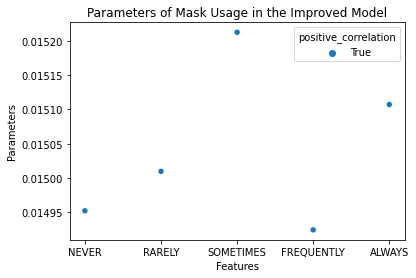

In [27]:
# 3: parameter of mask usage
sns.scatterplot(data=param_df.iloc[2:7,:], x="Features", y="Parameters", hue="positive_correlation")
plt.title("Parameters of Mask Usage in the Improved Model");

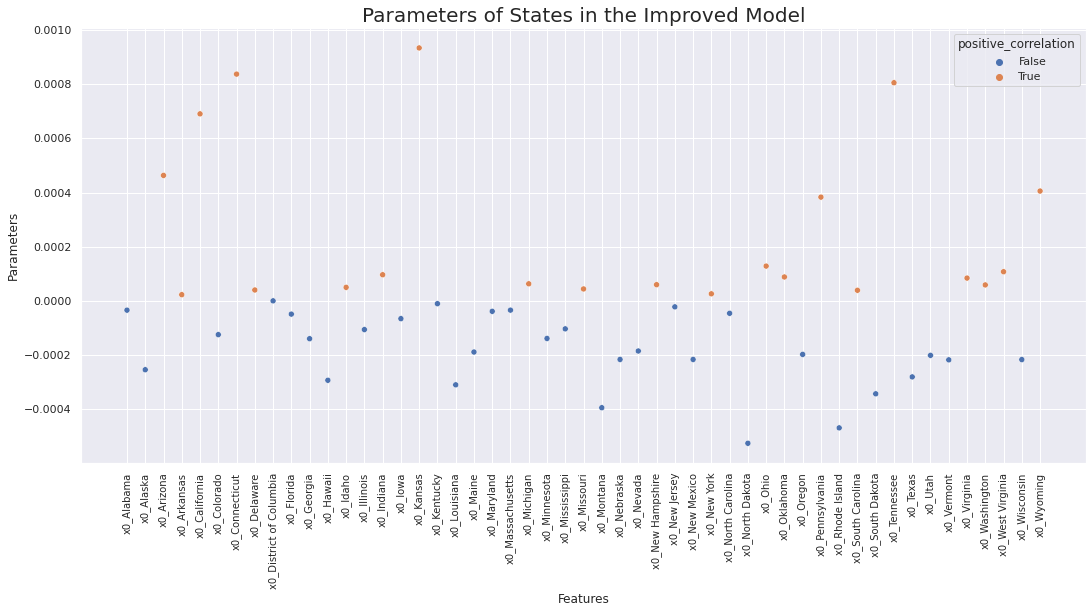

In [63]:
# 4: parameter of states
sns.set(rc={'figure.figsize':(18,8)})
sns.scatterplot(data=param_df.iloc[7:,:], x="Features", y="Parameters", hue="positive_correlation")
plt.title("Parameters of States in the Improved Model",size=20)
plt.xticks(rotation=90)
plt.xticks(fontsize=10);

___Comment:___

1. Comparing the two parameters of the same feature--the parameter of $x_{t}$ itself--of the baseline model and the improved model, we found that they are very close: 1.0029 in the improved model and 1.0025 in the baseline model. The positive parameters indicate a positive correlation between the number of cases on day t and the number of cases on day t+1. Intuitively, the cases won't increase dramatically in only one day so the parameter is basically equal to 1.
2. The parameter of the population density feature is 0, indicating there's no linear relationship between population density and the number of cases in our model. This is probably because we use the number of cases _per capita_ instead of the direct number to represent $x_{t}$ and $x_{t+1}$, that is to say, the "population density" information has already been included in the feature $x_{t}$. 
3. The parameters of the mask usage features are all positive, and there's no pattern between the number and the levels. This indicates that there's no obvious relationship between mask usage and the cases.
4. The parameters of the states are listed in the above figure. The North Dakota has the lowest parameter and the Kansas has the highest. We can intuitively interpret a positive parameter as the corresponding state did not do very well in preventing the COVID-19 spread, or it had a better detect ability as the data collected here is clearly not the actual number of cases in.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6d

Discuss your improved model's performance on both short-term and long-term time scales using a metric of your choice (*hint:* we're using an autoregressive model). In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for two $k$ values of your choice. You may use any reasonable interpretation of short-term and long-term predictions; an initial suggestion is to use 2-day predictions and 2-week predictions.

Compare the performance of this model on both timescales with the baseline model.

<!--
BEGIN QUESTION
name: q6d
points: 0
manual: True
-->

In [29]:
q6d_data = county_data.copy()
q6d_data["1/3/21_capital"] = q6d_data["1/3/21"].div(q6d_data["POPESTIMATE2020"], axis=0)
q6d_data["12/23/20_capital"] = q6d_data["12/23/20"].div(q6d_data["POPESTIMATE2020"], axis=0)

In [30]:
# short-term: choose first k = 2, a 2-day prediction
y_2days = q6d_data["12/23/20_capital"]
X_2d_train, X_2d_test, y_2d_train, y_2d_test = train_test_split(X_improved, y_2days, test_size=0.2, random_state=42)

f_improved_2d = lm.LinearRegression(fit_intercept=True)
f_improved_2d.fit(X_2d_train, y_2d_train)

prediction_2d_train = f_improved_2d.predict(X_2d_train)
prediction_2d_test = f_improved_2d.predict(X_2d_test)

rmse_2d_train = rmse(prediction_2d_train, y_2d_train)
rmse_2d_test = rmse(prediction_2d_test, y_2d_test)


In [31]:
# long-term: choose second k = 14, a 2-week prediction
y_2weeks = q6d_data["1/3/21_capital"]
X_2w_train, X_2w_test, y_2w_train, y_2w_test = train_test_split(X_improved, y_2weeks, test_size=0.2, random_state=42)

f_improved_2w = lm.LinearRegression(fit_intercept=True)
f_improved_2w.fit(X_2w_train, y_2w_train)

prediction_2w_train = f_improved_2w.predict(X_2w_train)
prediction_2w_test = f_improved_2w.predict(X_2w_test)

rmse_2w_train = rmse(prediction_2w_train, y_2w_train)
rmse_2w_test = rmse(prediction_2w_test, y_2w_test)


In [32]:
short_long_df = pd.DataFrame(np.array([["2 Days","2", rmse_2d_train.round(6), rmse_2d_test.round(6)],
                                       ["2 Weeks","14", rmse_2w_train.round(6), rmse_2w_test.round(6)]]),
                   columns=["Term","k", 'Training_rmse', 'Testing_rmse'])
short_long_df 

,Term,k,Training_rmse,Testing_rmse
0,2 Days,2,0.000958,0.001054
1,2 Weeks,14,0.003351,0.003522


___Comment:___

In the long-term (in this case, 2 weeks), the training and testing rmse are both tripled comparing to the short-term (2 days), indicating our improved model performed much worse in making long-term predictions.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6e

Plot and describe the error for both the baseline and improved models as a function of time. In other words, given $x_t$, we wish to predict $\hat{x}_{t+k}$, and plot the error of these predictions for all $k$.

Consider how and why the performance of the model degrades as a function of time using the rate of growth in the error.

<!--
BEGIN QUESTION
name: q6e
points: 0
manual: True
-->

__1. For this question, use the whole data set to train the model, no train-test split__.<br>
__2. Using k from 1 to 200, i.e., when $x_{t}$ is the number of cases per capital on day 12/20/20, we predict the number of cases per capital from day 12/21/20 to 7/8/21.__

In [58]:
# Using per capital data
q6e_data = county_data.copy()
for i in range(365, 567): 
    # from 12/20/20 to 7/8/21
    q6e_data.iloc[:,i] = q6e_data.iloc[:,i]/q6e_data["POPESTIMATE2020"]
q6e_data = q6e_data.loc[:, "12/21/20":"7/8/21"]

In [62]:
# RMSE for both models from k=1 to k=200
rmse_base = []
rmse_improved = []
for y in q6e_data.columns:
    y = q6e_data[y]
    
    f_base = lm.LinearRegression(fit_intercept=True)
    f_base.fit(X_base, y)
    f_improved = lm.LinearRegression(fit_intercept=True)
    f_improved.fit(X_improved, y)
 
    rmse_base.append(rmse(f_base.predict(X_base), y))
    rmse_improved.append(rmse(f_improved.predict(X_improved), y))

In [60]:
# RMSE and growth rate into a dataframe
growth_rate_base = [(rmse_base[n]-rmse_base[n-1])/rmse_base[n-1] for n in range(1,len(rmse_base))]
growth_rate_base.insert(0, 0)

growth_rate_improved = [(rmse_improved[n]-rmse_improved[n-1])/rmse_improved[n-1] for n in range(1,len(rmse_improved))]
growth_rate_improved.insert(0, 0)

q6e_df = pd.DataFrame(np.array([range(1, 201), rmse_base, growth_rate_base, rmse_improved, growth_rate_improved]).T,
                   columns=["k", 'Baseline_model_rmse','Baseline_growth_rate', 'Improved_model_rmse', 'Improved_growth_rate'])

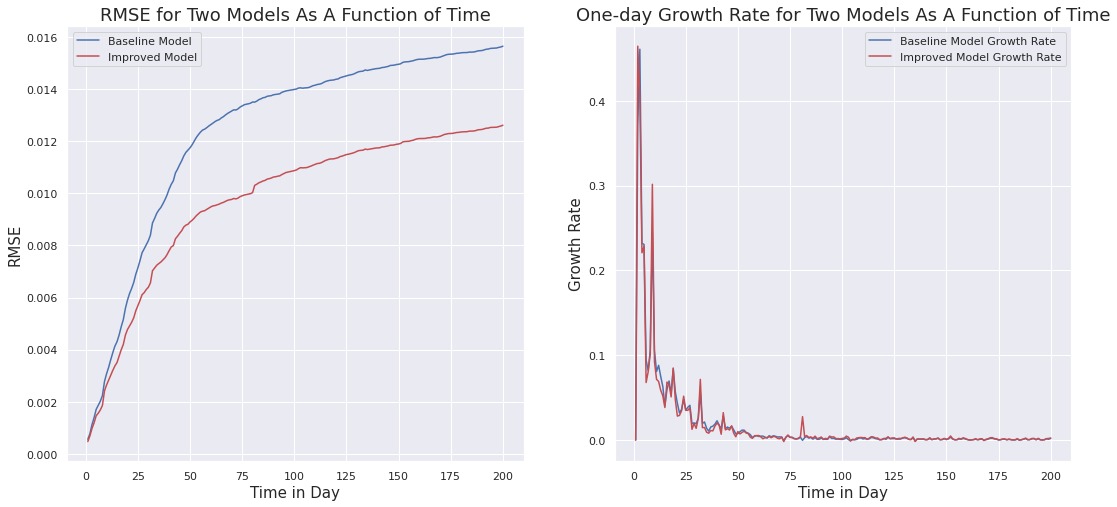

In [61]:
plt.subplot(1,2,1)
plt.plot(q6e_df["k"], q6e_df["Baseline_model_rmse"], "b", label = "Baseline Model")
plt.plot(q6e_df["k"], q6e_df["Improved_model_rmse"], "r", label = "Improved Model")
plt.legend();
plt.xlabel("Time in Day",size=15)
plt.ylabel("RMSE",size=15)
plt.title("RMSE for Two Models As A Function of Time", size=18);

plt.subplot(1,2,2)
plt.plot(q6e_df["k"], q6e_df["Baseline_growth_rate"], "b", label = "Baseline Model Growth Rate")
plt.plot(q6e_df["k"], q6e_df["Improved_growth_rate"], "r", label = "Improved Model Growth Rate")
plt.legend();
plt.xlabel("Time in Day",size=15)
plt.ylabel("Growth Rate",size=15)
plt.title("One-day Growth Rate for Two Models As A Function of Time", size=18);

___Comment:___<br>

In both models, RMSE is similar to a logarithmic function of time: it grows very rapidly in the first 50 days, and then slowly slows down. It can also be seen from the one-day growth rate that in the first few days the rate was very high with the peak reached nearly 0.5; after 10 days it stabilized to below 0.1, and after 50 days it was almost equal to 0.


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 6f

Consider a modification to the model $f(x) = x_{t+1}$ where instead $f(x) = [x_{t+1}, x_{t+2}, ..., x_{t+m}]$ for some $m > 1$. In other words, using the features $x$ that contain past and present quantities, our model *explicitly* predicts values for $m$ days in the future rather than simply the next day (i.e. $m = 1$). 

Train the baseline and improved model using $m = 5$ and $m = 10$. Evaluate and visualize the predictive accuracy of both models.

<!--
BEGIN QUESTION
name: q6f
points: 0
manual: True
-->

In [37]:
...

Ellipsis

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [38]:
grader.check_all()

q1a results: All test cases passed!

q1d results: All test cases passed!

q1e results: All test cases passed!

q5b results: All test cases passed!

q5d results: All test cases passed!

q5f results: All test cases passed!

q5g results: All test cases passed!

q5i results:
    q5i - 1 result:
        Trying:
            avg_var <= 1e-5
        Expecting:
            True
        **********************************************************************
        Line 1, in q5i 0
        Failed example:
            avg_var <= 1e-5
        Exception raised:
            Traceback (most recent call last):
              File "/opt/conda/lib/python3.9/doctest.py", line 1336, in __run
                exec(compile(example.source, filename, "single",
              File "<doctest q5i 0[0]>", line 1, in <module>
                avg_var <= 1e-5
            NameError: name 'avg_var' is not defined

    q5i - 2 result:
        Trying:
            avg_mse <= 5e-3
        Expecting:
            True
        *

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [39]:
# Save your notebook first, then run this cell to export your submission.
grader.export()